<a href="https://colab.research.google.com/github/fedeStaffo/AssignmentsDataScience/blob/main/Project%201/Clustering/clustering_uk_roads_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ensure that the Kaggle library is installed for interacting with Kaggle datasets
!pip install kaggle

# Download the dataset from Kaggle using its specific identifier
!kaggle datasets download -d tsiaras/uk-road-safety-accidents-and-vehicles

# Extract the contents of the downloaded zip file into the specified directory
!unzip uk-road-safety-accidents-and-vehicles.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/tsiaras/uk-road-safety-accidents-and-vehicles
License(s): DbCL-1.0
 96% 136M/142M [00:01<00:00, 159MB/s]
100% 142M/142M [00:01<00:00, 139MB/s]
Archive:  uk-road-safety-accidents-and-vehicles.zip
  inflating: /content/dataset/Accident_Information.csv  
  inflating: /content/dataset/Vehicle_Information.csv  


In [2]:
import pandas as pd
import os

# Check the files available in the dataset directory
print(os.listdir('/content/dataset/'))  # Verify the file names in the directory

# Load the accident dataset and remove unnecessary columns
accidents_df = pd.read_csv('/content/dataset/Accident_Information.csv') \
    .drop(columns=['InScotland', 'Police_Force', 'LSOA_of_Accident_Location',
                   'Location_Easting_OSGR', 'Location_Northing_OSGR'])

# Load the vehicle dataset and remove unnecessary columns
vehicles_df = pd.read_csv('/content/dataset/Vehicle_Information.csv', encoding="ISO-8859-1") \
    .drop(columns=['Vehicle_Location.Restricted_Lane', 'Vehicle_Reference'])

# Extract one record every 10 in the accident dataset based on the date
accidents_df['Date'] = pd.to_datetime(accidents_df['Date'])  # Convert 'Date' column to datetime
accidents_df.sort_values(by='Date', inplace=True)  # Sort the data by date
accidents_df = accidents_df.iloc[::10, :]  # Select every 10th row

# Remove accidents without vehicle information through an inner join
# Note: Since accidents may involve multiple vehicles, duplicates are removed before merging
incidents_in_vehicle_df = vehicles_df[['Accident_Index']].drop_duplicates(subset='Accident_Index')
accidents_df = pd.merge(accidents_df, incidents_in_vehicle_df, on='Accident_Index', how='inner')

# Save the cleaned accident dataset to a CSV file
accidents_df.to_csv('/content/dataset/accident_etl.csv', index=False)

# Remove vehicles not associated with any accident in the cleaned accident dataset through an inner join
vehicles_df = pd.merge(accidents_df[['Accident_Index']], vehicles_df, on='Accident_Index', how='inner')

# Save the cleaned vehicle dataset to a CSV file
vehicles_df.to_csv('/content/dataset/vehicle_etl.csv', index=False)

# Confirm that the ETL process has been completed
print("ETL completed! Cleaned files have been saved as 'accident_etl.csv' and 'vehicle_etl.csv'.")


['Vehicle_Information.csv', 'Accident_Information.csv']


<ipython-input-2-b586e013593b>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents_df = pd.read_csv('/content/dataset/Accident_Information.csv') \


ETL completed! Cleaned files have been saved as 'accident_etl.csv' and 'vehicle_etl.csv'.


# Clustering preprocessing

Merging datasets...
Available columns in the combined dataset after merging:
Index(['Accident_Index', '1st_Road_Class', '1st_Road_Number', '2nd_Road_Class',
       '2nd_Road_Number', 'Accident_Severity', 'Carriageway_Hazards', 'Date',
       'Day_of_Week', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Local_Authority_(Highway)', 'Longitude',
       'Number_of_Casualties', 'Number_of_Vehicles',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions',
       'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit', 'Time',
       'Urban_or_Rural_Area', 'Weather_Conditions', 'Year_x',
       'Age_Band_of_Driver', 'Age_of_Vehicle', 'Driver_Home_Area_Type',
       'Driver_IMD_Decile', 'Engine_Capacity_.CC.',
       'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway',
       'Journey_Purpose_of_Driver', 'Jun

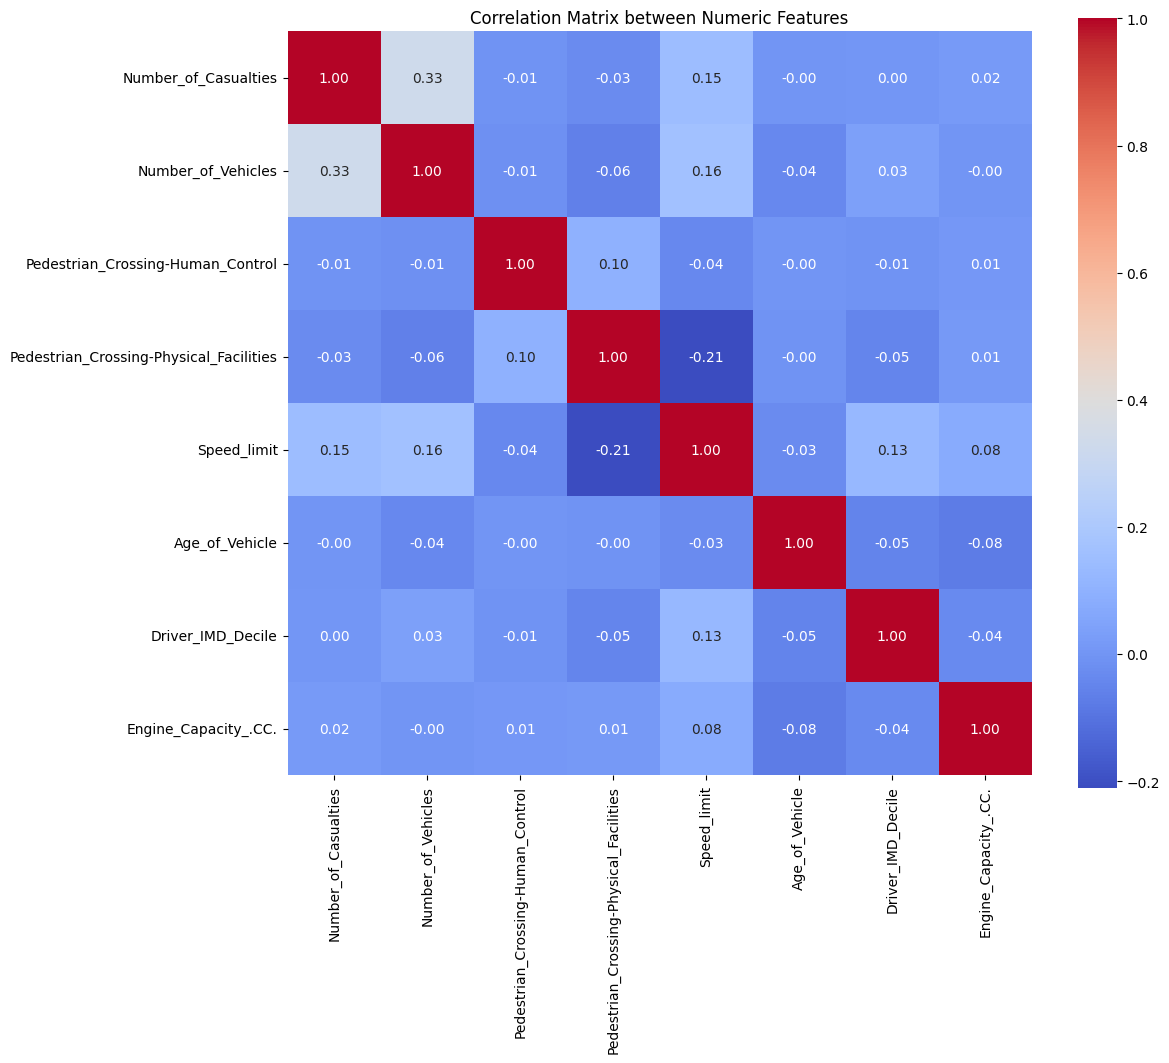

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the cleaned datasets
try:
    accidents_df = pd.read_csv('/content/dataset/accident_etl.csv')
    vehicles_df = pd.read_csv('/content/dataset/vehicle_etl.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")
    exit()

# Merge the datasets on the 'Accident_Index' column
print("Merging datasets...")
combined_df = pd.merge(accidents_df, vehicles_df, on='Accident_Index', how='inner')
print("Available columns in the combined dataset after merging:")
print(combined_df.columns)

# Remove irrelevant columns using feature selection
columns_to_drop = [
    '1st_Road_Number', '2nd_Road_Number', 'Date',
    'Did_Police_Officer_Attend_Scene_of_Accident', 'Junction_Control',
    'Junction_Detail', 'Latitude', 'Local_Authority_(District)',
    'Local_Authority_(Highway)', 'Longitude', 'Special_Conditions_at_Site',
    'Year_x', 'Journey_Purpose_of_Driver', 'Junction_Location', 'make', 'model',
    'Propulsion_Code', 'Sex_of_Driver', 'Skidding_and_Overturning',
    'Towing_and_Articulation', 'Vehicle_Leaving_Carriageway',
    'Was_Vehicle_Left_Hand_Drive', 'X1st_Point_of_Impact', 'Year_y'
]

# Drop the selected columns
combined_df_reduced = combined_df.drop(columns=columns_to_drop)
print("Available columns in the combined dataset after removing irrelevant columns:")
print(combined_df_reduced.columns)

# Filter numeric columns
numeric_features = combined_df_reduced.select_dtypes(include=[np.number])
print("Available numeric columns:")
print(numeric_features.columns)

# Check for NaN or Inf values
print("Checking for NaN and Inf...")
if numeric_features.isnull().any().any() or not np.isfinite(numeric_features).all().all():
    print("The dataset contains NaN or Inf. Resolving...")

    # Use median imputation to replace NaN or Inf values
    imputer = SimpleImputer(strategy='median')
    numeric_features = pd.DataFrame(imputer.fit_transform(numeric_features), columns=numeric_features.columns)

print("Numeric columns available after imputing missing values:")
print(numeric_features.columns)

# Correlation matrix
print("Calculating the correlation matrix for numeric features...")
correlation_matrix = numeric_features.corr()

# Plot the original correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix between Numeric Features')
plt.show()


# 1. Bidimensional Clustering

## Correlation study

In [ ]:
# Find the pair of features with the highest correlation (excluding the diagonal)
correlation_values = correlation_matrix.unstack().sort_values(ascending=False)
selected_pairs = correlation_values[correlation_values < 1.0]  # Exclude perfect correlation (diagonal)
top_pair = selected_pairs.idxmax()  # Pair with the highest correlation

# Display the selected pair
feature_1, feature_2 = top_pair
print(f"The two features with the highest correlation are: {feature_1} and {feature_2}")

# Display unique values in feature_1 (sorted)
print(f"Unique values in {feature_1} (sorted):")
print(sorted(numeric_features[feature_1].unique()))

# Display unique values in feature_2 (sorted)
print(f"\nUnique values in {feature_2} (sorted):")
print(sorted(numeric_features[feature_2].unique()))


### K-Means

Link: [Elbow method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/#understanding-distortion-and-inertia-in-kmeans-clustering)

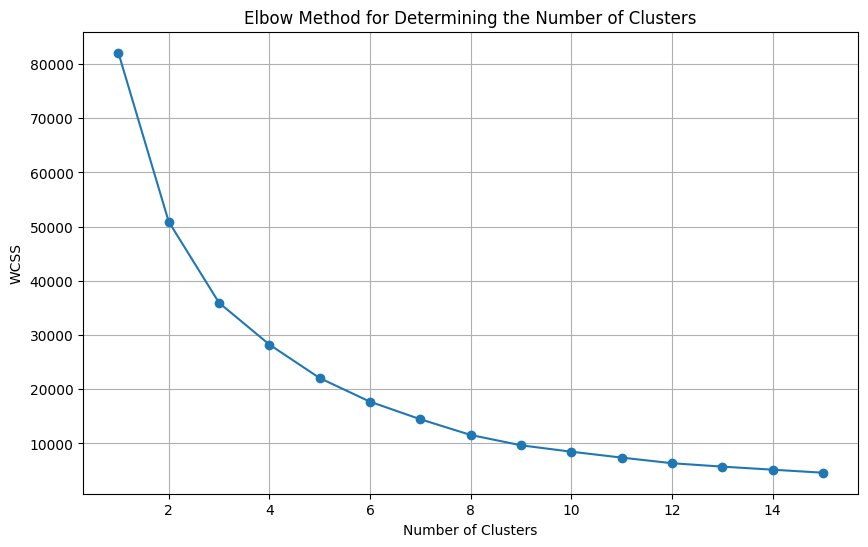

Chosen number of clusters: 4
Silhouette Score for KMeans with 4 clusters: 0.630
Cluster 0: 30898 elements (61.80% of total samples)
Cluster 1: 7925 elements (15.85% of total samples)
Cluster 2: 1870 elements (3.74% of total samples)
Cluster 3: 9307 elements (18.61% of total samples)


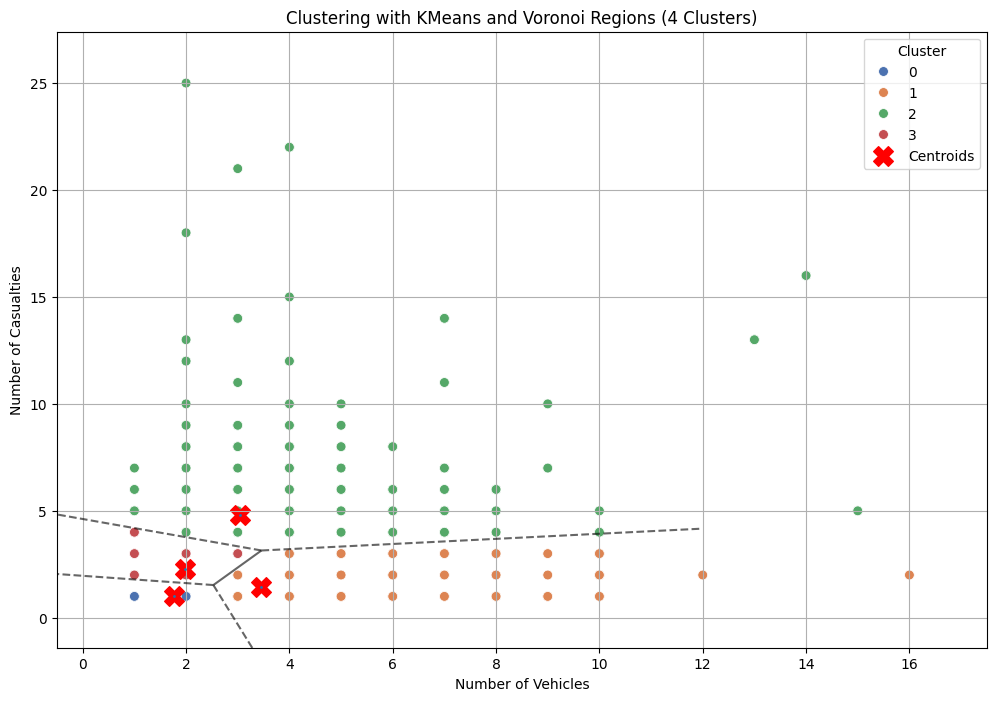

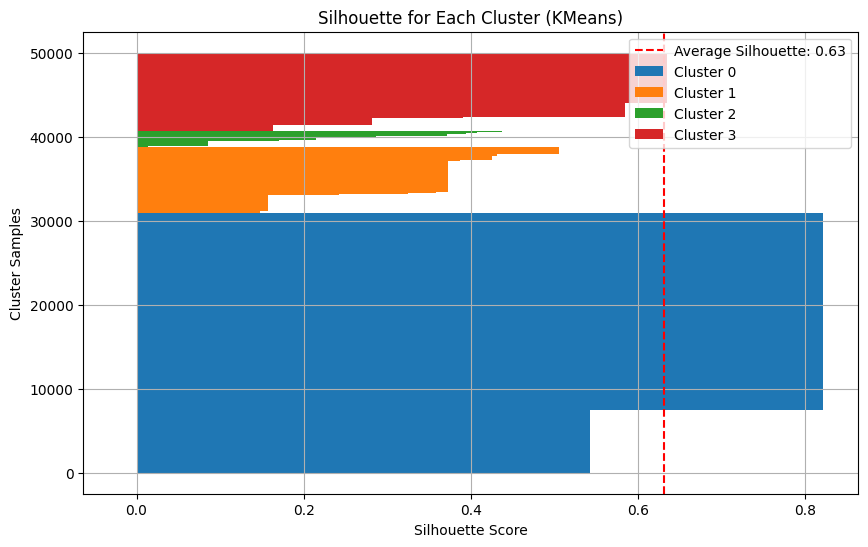

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import Voronoi, voronoi_plot_2d
import seaborn as sns
from sklearn.utils import resample

# Remove the specific unique values and prepare the data
filtered_data = numeric_features[
    (numeric_features['Number_of_Vehicles'] != 29) &
    (numeric_features['Number_of_Casualties'] != 87)
].dropna()

# Sample a maximum of 50,000 rows if the dataset is larger
max_samples = 50000
if len(filtered_data) > max_samples:
    sampled_data = resample(filtered_data, n_samples=max_samples, random_state=42)
else:
    sampled_data = filtered_data.copy()

# Dataset for clustering (make a copy to avoid SettingWithCopyWarning)
clustering_data = sampled_data[['Number_of_Vehicles', 'Number_of_Casualties']].copy()

# Elbow method to determine the optimal number of clusters
wcss = []  # Within-cluster sum of squares (WCSS)
max_k = 15  # Maximum number of clusters to try
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(clustering_data)  # Using raw data (no scaling)
    wcss.append(kmeans.inertia_)

# Elbow curve plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Determining the Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (manual or automatic)
n_clusters = 4  # Modify this based on the elbow curve
print(f"Chosen number of clusters: {n_clusters}")

# Perform KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(clustering_data)

# Calculate the Silhouette Score
silhouette_kmeans = silhouette_score(clustering_data, kmeans_labels)
print(f"Silhouette Score for KMeans with {n_clusters} clusters: {silhouette_kmeans:.3f}")

# Calculate the silhouette score for each point
silhouette_values = silhouette_samples(clustering_data, kmeans_labels)

# --- Print number of elements per cluster and percentage of total samples ---
unique, counts = np.unique(kmeans_labels, return_counts=True)
for label, count in zip(unique, counts):
    percentage = (count / len(clustering_data)) * 100
    print(f"Cluster {label}: {count} elements ({percentage:.2f}% of total samples)")

# Scatter plot with Voronoi using the raw data
plt.figure(figsize=(12, 8))

# Centroids calculated by the KMeans model
centroids = kmeans.cluster_centers_

# Calculate the Voronoi regions
vor = Voronoi(centroids)

# Draw the Voronoi regions with black lines
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='black', line_width=1.5, line_alpha=0.6, point_size=2)

# Scatter plot of the data with original features
sns.scatterplot(x=clustering_data['Number_of_Vehicles'], y=clustering_data['Number_of_Casualties'], hue=kmeans_labels, palette='deep', s=50, legend='full')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', label='Centroids', marker='X')

# Expand axis limits to avoid cutting
x_min, x_max = clustering_data['Number_of_Vehicles'].min(), clustering_data['Number_of_Vehicles'].max()
y_min, y_max = clustering_data['Number_of_Casualties'].min(), clustering_data['Number_of_Casualties'].max()
plt.xlim(x_min - 0.1 * abs(x_max - x_min), x_max + 0.1 * abs(x_max - x_min))
plt.ylim(y_min - 0.1 * abs(y_max - y_min), y_max + 0.1 * abs(y_max - y_min))

# Aesthetic changes
plt.title(f'Clustering with KMeans and Voronoi Regions ({n_clusters} Clusters)')
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Casualties')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Plot of the silhouette for each cluster
plt.figure(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(n_clusters):
    # Get the silhouette values for the cluster
    cluster_silhouette_values = silhouette_values[kmeans_labels == i]
    cluster_silhouette_values.sort()

    # Update spaces between clusters
    y_upper += len(cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', label=f"Cluster {i}")
    y_lower += len(cluster_silhouette_values)

# Dashed vertical line for the average silhouette value
plt.axvline(x=silhouette_kmeans, color="red", linestyle="--", label=f"Average Silhouette: {silhouette_kmeans:.2f}")

# Aesthetic changes
plt.title(f"Silhouette for Each Cluster (KMeans)")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster Samples")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


# 2. Multidimensional Clustering with PCA

Numeric features standardized.


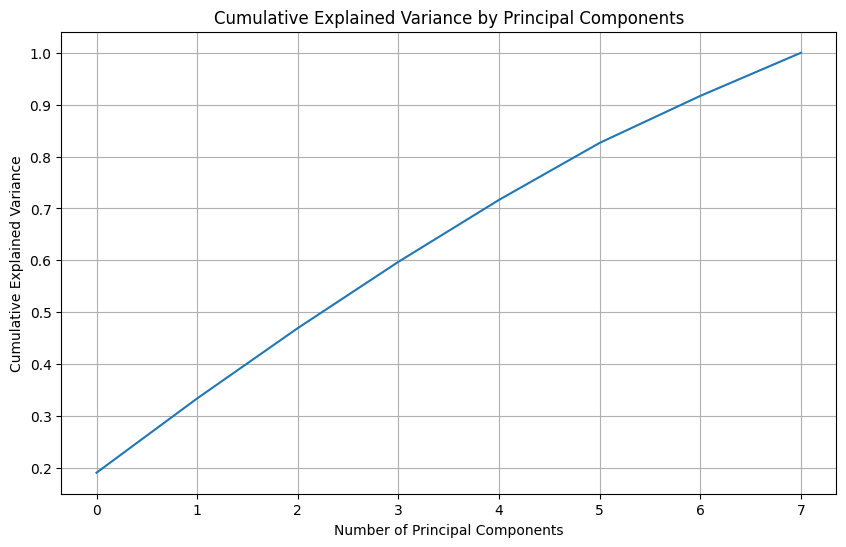

Number of principal components to keep: 7
Available columns in the dataset after PCA:
Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'Accident_Index'], dtype='object')
Factor loadings (loadings):
                                              PC1       PC2       PC3  \
Number_of_Casualties                     0.505513  0.462970  0.134777   
Number_of_Vehicles                       0.541429  0.378361  0.101364   
Pedestrian_Crossing-Human_Control       -0.122879  0.390574 -0.231035   
Pedestrian_Crossing-Physical_Facilities -0.334324  0.535118 -0.165589   
Speed_limit                              0.517859 -0.276977 -0.099506   
Age_of_Vehicle                          -0.102049  0.024846  0.672716   
Driver_IMD_Decile                        0.197244 -0.352772 -0.172248   
Engine_Capacity_.CC.                     0.083321  0.042674 -0.631384   

                                              PC4       PC5       PC6  \
Number_of_Casualties                    -0.031214 -0.082016  0.0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#-------------------------------------------

# Standardization of numeric features
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)
print("Numeric features standardized.")

# Apply PCA
pca = PCA()
pca.fit(numeric_features_scaled)

# Sum of explained variances
explained_variance_ratio = pca.explained_variance_ratio_

# Plot of explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine how many principal components explain at least 90% of the variance
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_to_keep = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of principal components to keep: {n_components_to_keep}")

# Reduce the dimensionality to n_components_to_keep
pca = PCA(n_components=n_components_to_keep)
principal_components = pca.fit_transform(numeric_features_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components_to_keep)])

# Add the Accident Index
pca_df['Accident_Index'] = combined_df_reduced['Accident_Index'].values
print("Available columns in the dataset after PCA:")
print(pca_df.columns)

# Factor loading matrix
loadings = pd.DataFrame(
    data=pca.components_.T,  # Transpose to have features as rows
    columns=[f'PC{i+1}' for i in range(n_components_to_keep)],  # Names of components
    index=numeric_features.columns  # Names of original features
)

# Show the top 5 loadings for each component
print("Factor loadings (loadings):")
print(loadings)

# Identify the most important features for each component
for i in range(n_components_to_keep):
    print(f"\nMost influential features for PC{i+1}:")
    print(loadings.iloc[:, i].sort_values(ascending=False).head(5))


### Meaning of **PC1** and **PC2**:
- **PC1 (First Principal Component)** represents the direction in which the data has the highest variance. The variables that contribute the most to PC1 (in descending order of importance) are:
  - **Number_of_Vehicles (0.541429)**: More vehicles per accident, the more this data will contribute to this component.
  - **Speed_limit (0.517859)**: Speed limits are also important for PC1.
  - **Number_of_Casualties (0.505513)**: The number of casualties in an accident has a positive correlation with PC1.
  - Other variables like **Driver_IMD_Decile** and **Engine_Capacity_.CC.** contribute to a lesser extent.

  The combination of these variables suggests that PC1 primarily captures the variability associated with the severity of the accident, the number of vehicles involved, and the severity of the speed limit.

- **PC2 (Second Principal Component)** is orthogonal to PC1, so it captures the variance not captured by the first component. The most influential variables for PC2 are:
  - **Pedestrian_Crossing-Physical_Facilities (0.535118)**: The presence of pedestrian crossing facilities is one of the strongest variables in this component.
  - **Number_of_Casualties (0.462970)**: The number of casualties continues to have an impact on this component as well.
  - **Pedestrian_Crossing-Human_Control (0.390574)**: The presence of human-controlled pedestrian crossings also influences this component.
  - Again, **Number_of_Vehicles** has a significant contribution.

  Therefore, PC2 seems to capture the variability related to pedestrian crossing conditions, both physical and human-controlled, and how these relate to the number of casualties and the type of incident.

### Interpretation of Clustering with PC1 and PC2:
When performing clustering using PC1 and PC2, you are essentially trying to group accidents based on a combination of factors related to accident severity, the number of vehicles involved, road conditions, and pedestrian crossing management. These groups (clusters) could represent, for example:
- **Cluster 1**: Accidents with many vehicles and high severity, possibly in urban areas with high-speed limits.
- **Cluster 2**: Accidents with fewer vehicles but high mortality, perhaps in particular road conditions or areas with poor visibility.
- **Cluster 3**: Accidents with a significant presence of pedestrians or pedestrian crossing conditions, which may differ from other clusters due to pedestrian safety management.

### Meaning of Other Principal Components:
- **PC3**: Represents variables such as vehicle age and the number of casualties. It might reflect the severity or type of vehicle involved in the accident, with more severe accidents related to older vehicles.
- **PC4**: Focuses on variables like the driver's IMD decile (deprivation indicator) and pedestrian crossing management. It may indicate that some areas or socio-economic groups are more prone to certain types of accidents.
- **PC5, PC6, PC7**: These components capture more specific variations, such as the interaction between vehicle type and road conditions, the driver's age, and environmental conditions like traffic or visibility.

In summary, clustering based on PC1 and PC2 allows you to identify groups of accidents that share similar characteristics, such as the number of vehicles involved, severity, pedestrian conditions, and other factors. The principal components provide insight into how the original variables interact with each other to influence the nature of the accidents.

## DBSCAN

Calculating nearest neighbors distances...


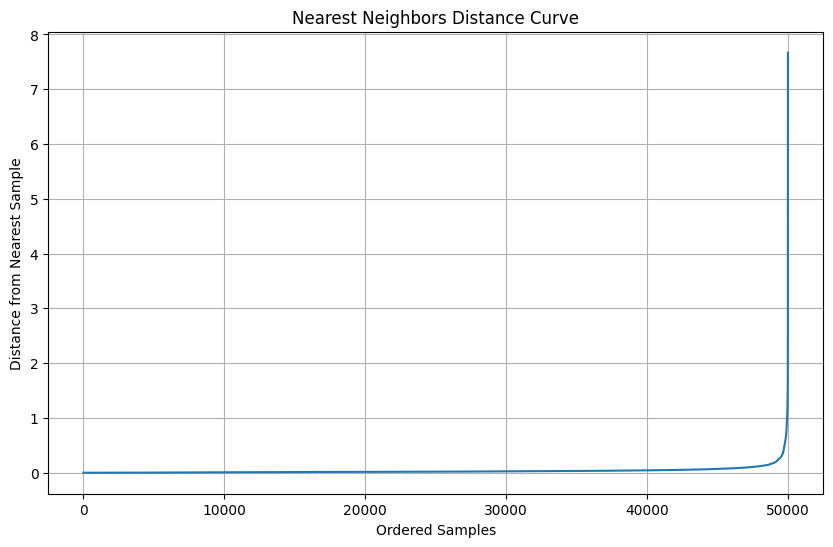

Chosen epsilon (eps) value: 0.10614092200213919
Chosen min_samples: 16
Running DBSCAN clustering...
Number of clusters found by DBSCAN: 15
Silhouette Score for DBSCAN: 0.262


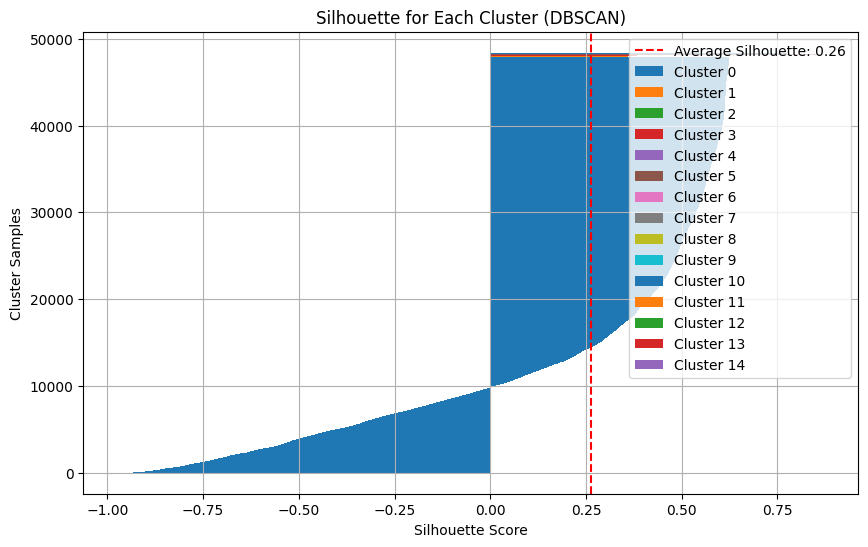

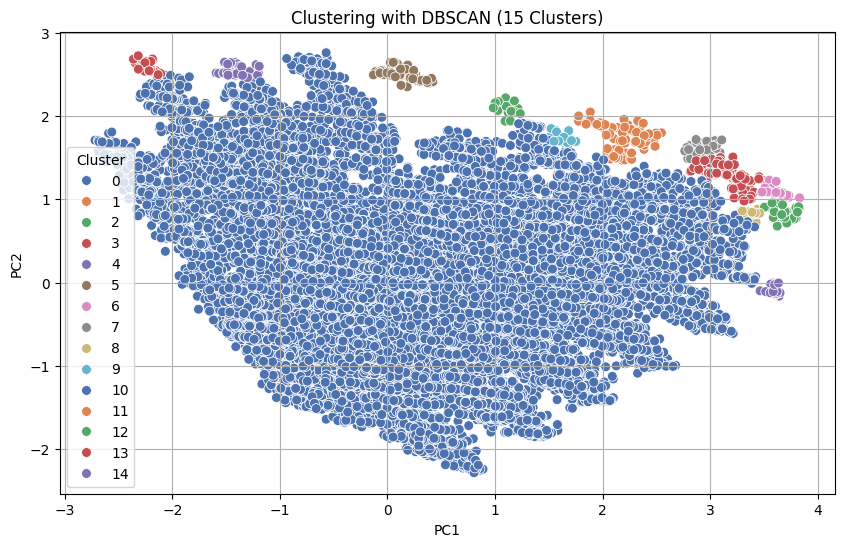

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select only PC1 and PC2 for clustering
X = pca_df[['PC1', 'PC2']].values

# Limit the sampling to 50,000 samples
sample_size = 50000
X_sampled = X[:sample_size]  # Sample data

# Normalize the sampled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sampled)

# Calculate the number of features (PC1 and PC2) to determine min_samples
n_features = X_scaled.shape[1]
min_samples = 2 * 8

# Calculate the distance of the k-nearest neighbors
print("Calculating nearest neighbors distances...")
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort the distances to visualize the curve
distances = np.sort(distances[:, -1], axis=0)

# Plot the nearest neighbors distance curve
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Nearest Neighbors Distance Curve')
plt.xlabel('Ordered Samples')
plt.ylabel('Distance from Nearest Sample')
plt.grid(True)
plt.show()

# Automatically choose the epsilon (eps) value as the "elbow" point
eps = distances[int(0.95 * len(distances))]  # Take the 95th percentile as eps

print(f"Chosen epsilon (eps) value: {eps}")
print(f"Chosen min_samples: {min_samples}")

# Perform DBSCAN clustering
print("Running DBSCAN clustering...")
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to a new dataframe (not the original pca_df) for the sampled data
sampled_df = pca_df.iloc[:sample_size].copy()  # Ensure we are working with the sampled data
sampled_df['DBSCAN_Cluster'] = dbscan_labels

# Number of clusters found
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

# Calculate the Silhouette Score only if there is more than 1 cluster
silhouette_dbscan = silhouette_score(X_scaled, dbscan_labels) if n_clusters_dbscan > 1 else None
print(f"Number of clusters found by DBSCAN: {n_clusters_dbscan}")
if silhouette_dbscan:
    print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.3f}")
else:
    print("Silhouette Score not calculable (only one cluster detected).")

# Calculate the silhouette score for each point
silhouette_values = silhouette_samples(X_scaled, dbscan_labels)

# Plot the silhouette for each cluster
plt.figure(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(n_clusters_dbscan):
    # Get silhouette values for the cluster, excluding noise (-1)
    cluster_silhouette_values = silhouette_values[dbscan_labels == i]
    cluster_silhouette_values.sort()

    # Update the spaces between clusters
    y_upper += len(cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', label=f"Cluster {i}")
    y_lower += len(cluster_silhouette_values)

# Dashed vertical line for the average silhouette value
if silhouette_dbscan:
    plt.axvline(x=silhouette_dbscan, color="red", linestyle="--", label=f"Average Silhouette: {silhouette_dbscan:.2f}")

# Plot adjustments
plt.title(f"Silhouette for Each Cluster (DBSCAN)")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster Samples")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Filter out noise (label -1) from the dataframe for plotting
filtered_df = sampled_df[sampled_df['DBSCAN_Cluster'] != -1]

# Scatter plot with DBSCAN
plt.figure(figsize=(10, 6))

# Display DBSCAN clusters (excluding noise, which has label -1)
sns.scatterplot(data=filtered_df, x='PC1', y='PC2', hue='DBSCAN_Cluster',
                palette='deep', s=50, legend='full')

plt.title(f'Clustering with DBSCAN ({n_clusters_dbscan} Clusters)')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


##  K-Means

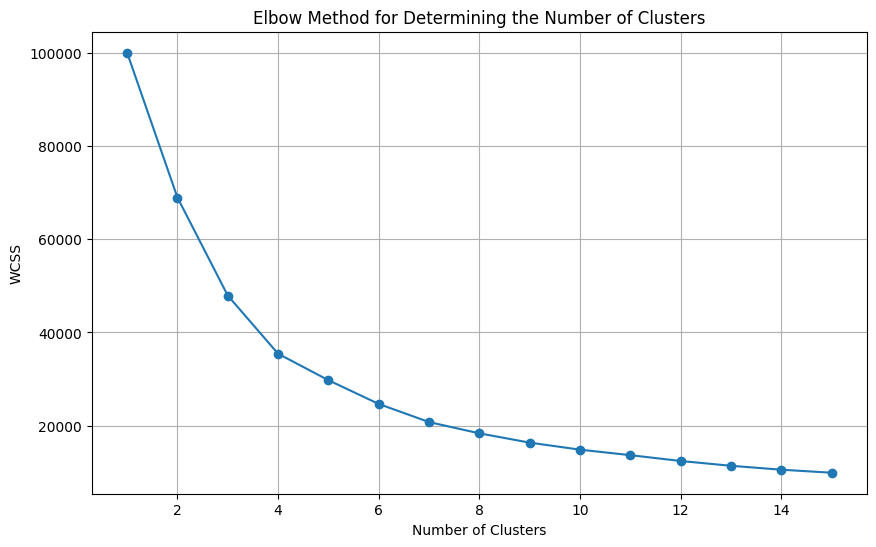

Chosen number of clusters: 4
Silhouette Score for KMeans with 4 clusters: 0.394
Cluster 0: 5362 elements (10.72% of total samples)
Cluster 1: 24378 elements (48.76% of total samples)
Cluster 2: 5487 elements (10.97% of total samples)
Cluster 3: 14773 elements (29.55% of total samples)


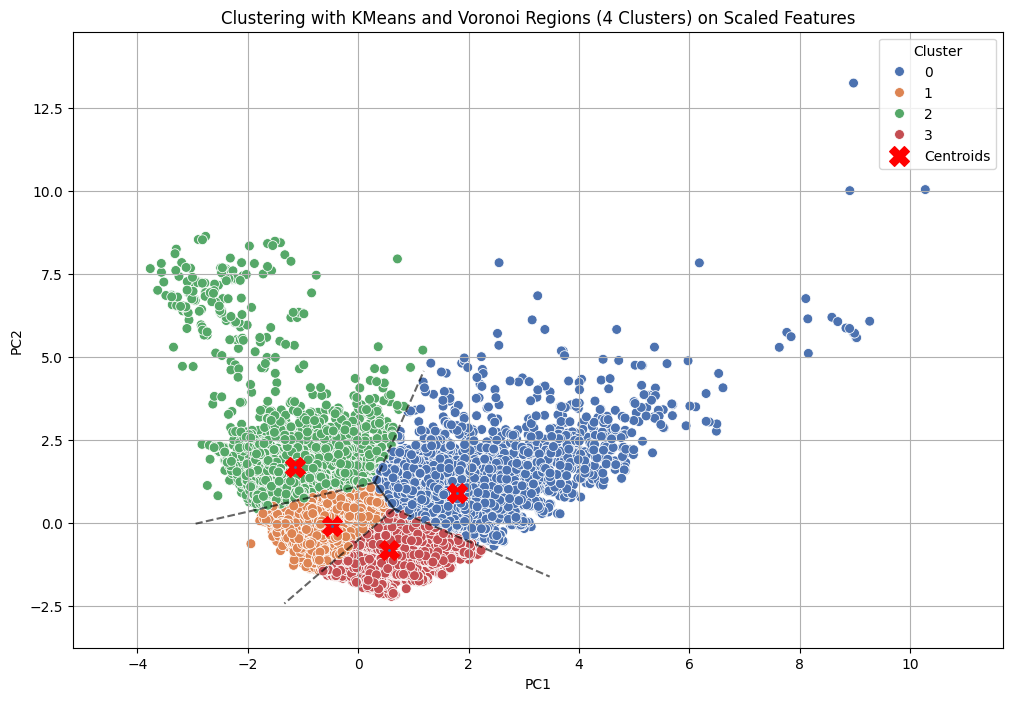

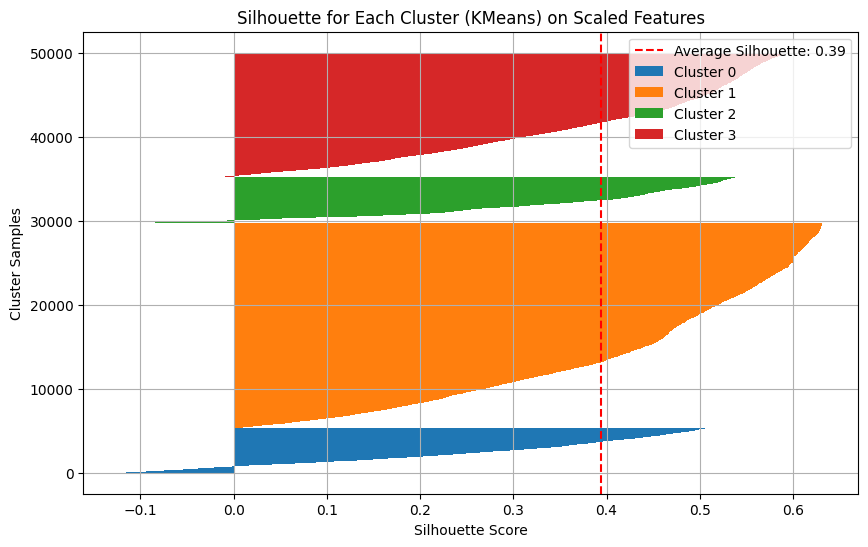

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial import Voronoi, voronoi_plot_2d
import seaborn as sns

# Assuming pca_df contains the PCA results (PC1, PC2)
X = pca_df[['PC1', 'PC2']].values

# Perform sampling
sample_size = 50000  # Maximum number of samples
X_sampled = X[:sample_size]

# Normalize the sampled data
scaler = StandardScaler()
X_sampled_scaled = scaler.fit_transform(X_sampled)

# Elbow method to determine the optimal number of clusters
wcss = []  # Within-cluster sum of squares (WCSS)
max_k = 15  # Maximum number of clusters to try
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_sampled_scaled)
    wcss.append(kmeans.inertia_)

# Elbow curve plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method for Determining the Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (manual or automatic)
n_clusters = 4  # You can modify this based on the elbow curve
print(f"Chosen number of clusters: {n_clusters}")

# Perform KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_sampled_scaled)

# Calculate the Silhouette Score
silhouette_kmeans = silhouette_score(X_sampled_scaled, kmeans_labels)
print(f"Silhouette Score for KMeans with {n_clusters} clusters: {silhouette_kmeans:.3f}")

# Calculate the silhouette score for each point
silhouette_values = silhouette_samples(X_sampled_scaled, kmeans_labels)

# --- Print number of elements per cluster and percentage of total samples ---
unique, counts = np.unique(kmeans_labels, return_counts=True)
for label, count in zip(unique, counts):
    percentage = (count / len(X_sampled)) * 100
    print(f"Cluster {label}: {count} elements ({percentage:.2f}% of total samples)")

# Scatter plot with Voronoi using the scaled data
plt.figure(figsize=(12, 8))

# Centroids calculated by the KMeans model
centroids = kmeans.cluster_centers_

# Calculate the Voronoi regions
vor = Voronoi(centroids)

# Draw the Voronoi regions with black lines
voronoi_plot_2d(vor, ax=plt.gca(), show_vertices=False, line_colors='black', line_width=1.5, line_alpha=0.6, point_size=2)

# Scatter plot of the data with scaled features
sns.scatterplot(x=X_sampled_scaled[:, 0], y=X_sampled_scaled[:, 1], hue=kmeans_labels, palette='deep', s=50, legend='full')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', label='Centroids', marker='X')

# Expand axis limits to avoid cutting
x_min, x_max = X_sampled_scaled[:, 0].min(), X_sampled_scaled[:, 0].max()
y_min, y_max = X_sampled_scaled[:, 1].min(), X_sampled_scaled[:, 1].max()
plt.xlim(x_min - 0.1 * abs(x_max - x_min), x_max + 0.1 * abs(x_max - x_min))
plt.ylim(y_min - 0.1 * abs(y_max - y_min), y_max + 0.1 * abs(y_max - y_min))

# Aesthetic changes
plt.title(f'Clustering with KMeans and Voronoi Regions ({n_clusters} Clusters) on Scaled Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Plot of the silhouette for each cluster
plt.figure(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(n_clusters):
    # Get the silhouette values for the cluster
    cluster_silhouette_values = silhouette_values[kmeans_labels == i]
    cluster_silhouette_values.sort()

    # Update spaces between clusters
    y_upper += len(cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', label=f"Cluster {i}")
    y_lower += len(cluster_silhouette_values)

# Dashed vertical line for the average silhouette value
plt.axvline(x=silhouette_kmeans, color="red", linestyle="--", label=f"Average Silhouette: {silhouette_kmeans:.2f}")

# Aesthetic changes
plt.title(f"Silhouette for Each Cluster (KMeans) on Scaled Features")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster Samples")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


## GMM Clustering
[Scikitlearn doc](https://scikit-learn.org/1.5/modules/mixture.html)

Silhouette Score for GMM with 4 clusters: 0.392
Cluster 0: 23497 elements (46.99% of total samples)
Cluster 1: 5538 elements (11.08% of total samples)
Cluster 2: 15501 elements (31.00% of total samples)
Cluster 3: 5464 elements (10.93% of total samples)


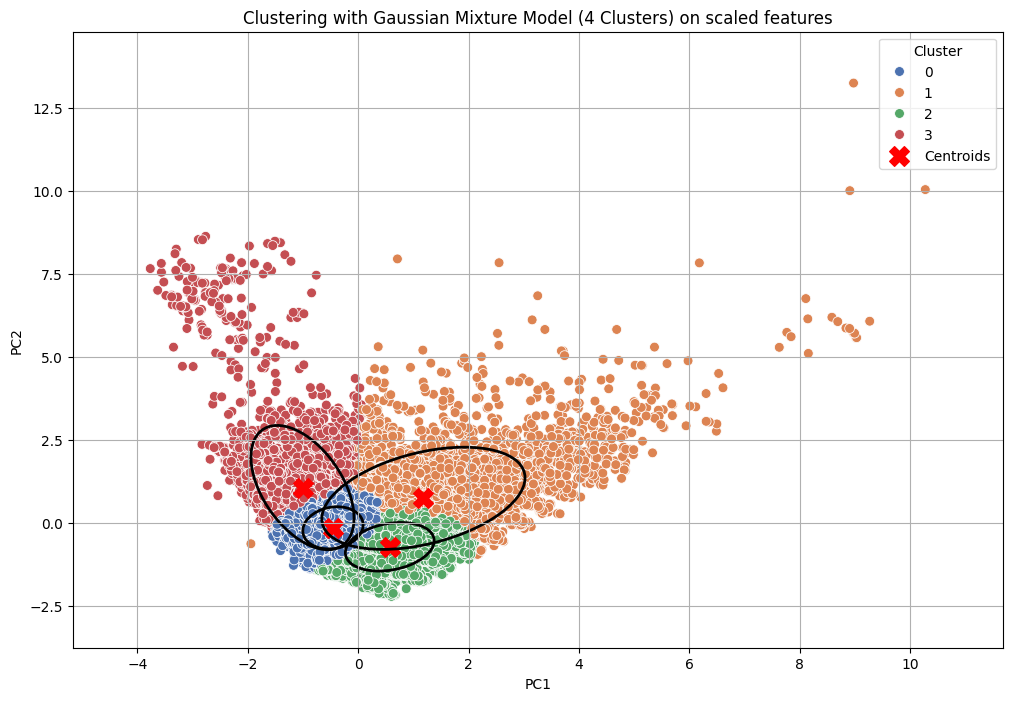

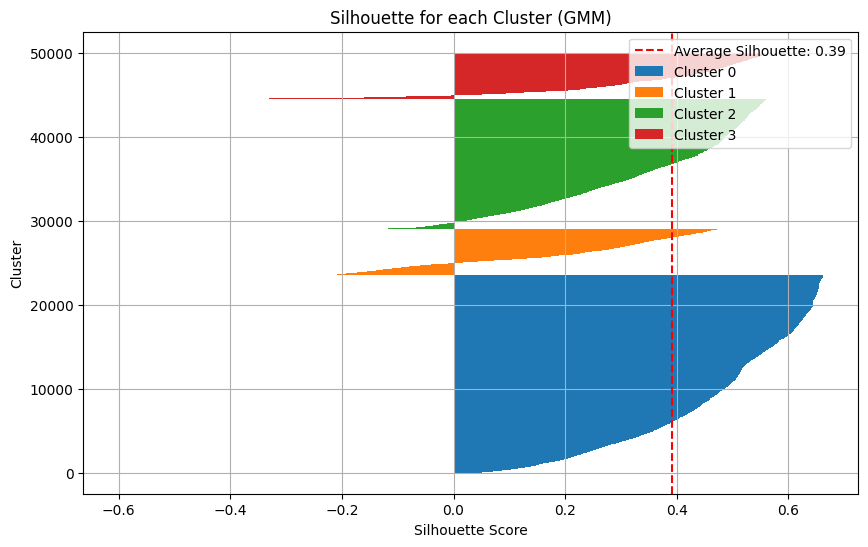

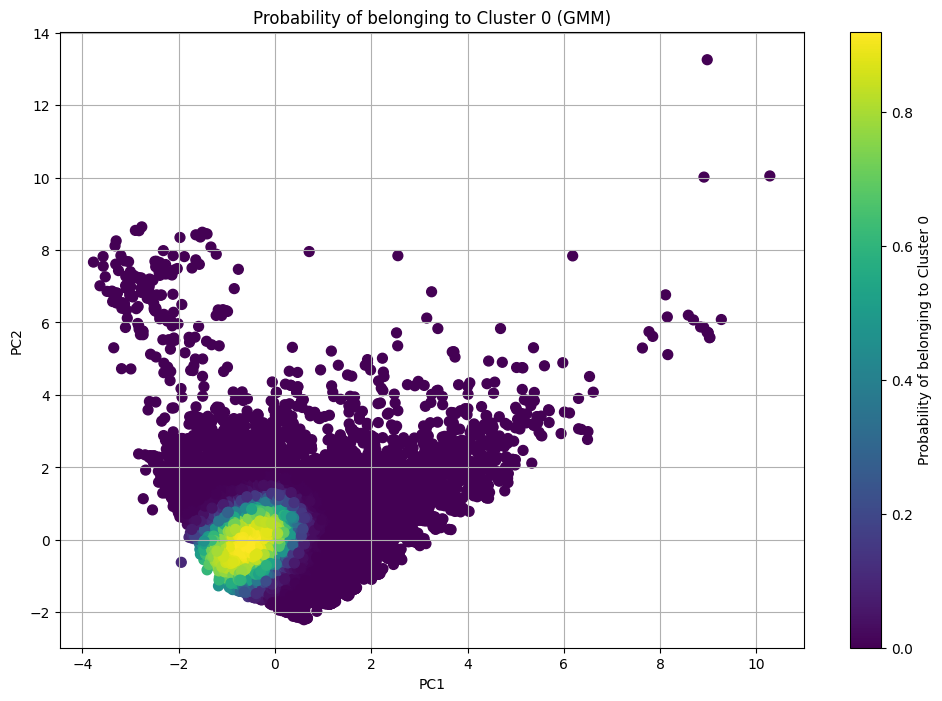

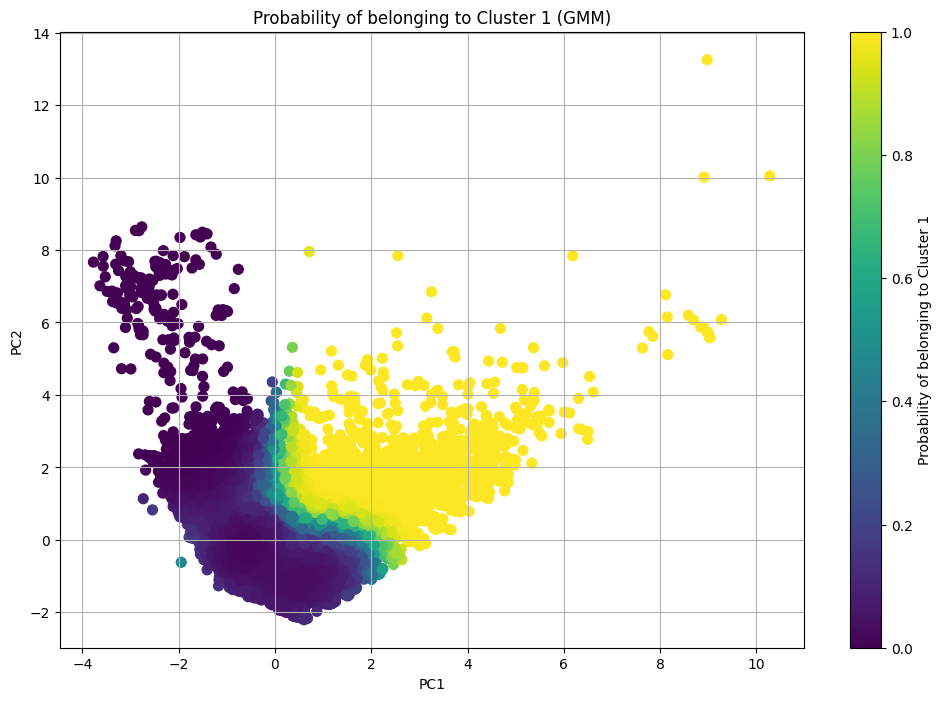

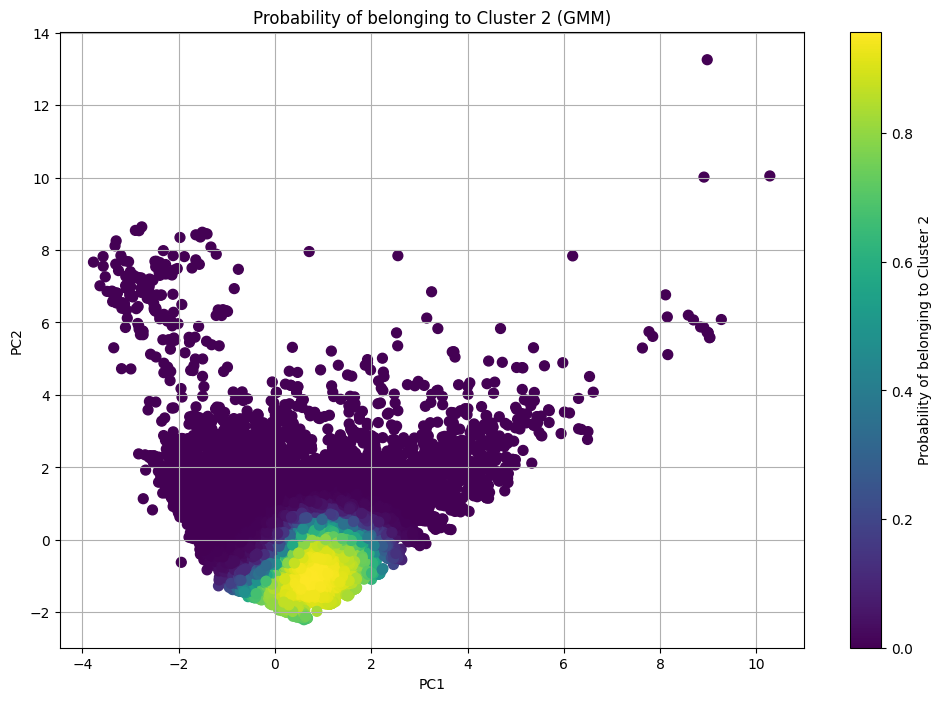

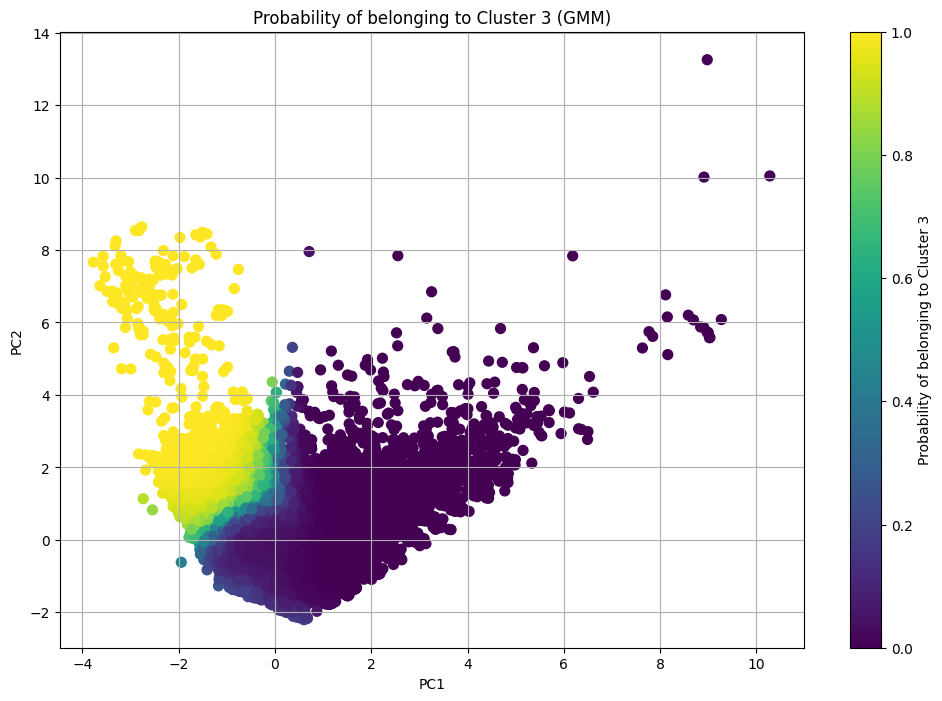

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

# Select only PC1 and PC2 for clustering
X = pca_df[['PC1', 'PC2']].values

# Perform sampling
sample_size = 50000  # Maximum number of samples
X_sampled = X[:sample_size]

# Normalize the data
scaler = StandardScaler()
X_sampled_scaled = scaler.fit_transform(X_sampled)

# Perform Gaussian Mixture Model (GMM)
n_clusters = 4  # Number of clusters chosen
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(X_sampled_scaled)

# Calculate the Silhouette Score
silhouette_gmm = silhouette_score(X_sampled_scaled, gmm_labels)
print(f"Silhouette Score for GMM with {n_clusters} clusters: {silhouette_gmm:.3f}")

# Calculate silhouette score for each point
silhouette_values = silhouette_samples(X_sampled_scaled, gmm_labels)

# Print number of elements per cluster and percentage of total samples
for i in range(n_clusters):
    cluster_size = np.sum(gmm_labels == i)
    percentage = (cluster_size / len(X_sampled)) * 100
    print(f"Cluster {i}: {cluster_size} elements ({percentage:.2f}% of total samples)")

# ---- Clustering Results Visualization ----
plt.figure(figsize=(12, 8))

# Centroids calculated from the GMM model (mean of each Gaussian distribution)
centroids = gmm.means_

# Plot the data points
sns.scatterplot(x=X_sampled_scaled[:, 0], y=X_sampled_scaled[:, 1], hue=gmm_labels, palette='deep', s=50, legend='full')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', label='Centroids', marker='X')

# Ellipses for each Gaussian component
for i in range(n_clusters):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    v, w = np.linalg.eigh(cov)  # Eigenvectors and eigenvalues of covariance matrix
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)  # Scaling factor for ellipse axes
    angle = np.arctan2(w[1, 0], w[0, 0])

    # Create ellipse
    angle = np.degrees(angle)
    ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=angle, color='black', lw=2, fill=False)
    plt.gca().add_patch(ell)

# Expand axis limits to avoid cutting
plt.xlim(x_min - 0.1 * abs(x_max - x_min), x_max + 0.1 * abs(x_max - x_min))
plt.ylim(y_min - 0.1 * abs(y_max - y_min), y_max + 0.1 * abs(y_max - y_min))

# Aesthetic changes
plt.title(f'Clustering with Gaussian Mixture Model ({n_clusters} Clusters) on scaled features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# ---- Silhouette Plot ----
plt.figure(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(n_clusters):
    # Get silhouette values for the cluster
    cluster_silhouette_values = silhouette_values[gmm_labels == i]
    cluster_silhouette_values.sort()

    # Update space between clusters
    y_upper += len(cluster_silhouette_values)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_values, height=1.0, edgecolor='none', label=f"Cluster {i}")
    y_lower += len(cluster_silhouette_values)

# Vertical dashed line for the average silhouette value
plt.axvline(x=silhouette_gmm, color="red", linestyle="--", label=f"Average Silhouette: {silhouette_gmm:.2f}")

# Aesthetic changes
plt.title(f"Silhouette for each Cluster (GMM)")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster")
plt.legend(loc="upper right")  # Set a specific position for the legend
plt.grid(True)
plt.show()

# ---- Membership Probability Visualization ----
probs = gmm.predict_proba(X_sampled_scaled)

# Create plots of membership probabilities for each cluster
for cluster_idx in range(n_clusters):
    plt.figure(figsize=(12, 8))

    # Display the membership probabilities for the current cluster
    scatter = plt.scatter(X_sampled_scaled[:, 0], X_sampled_scaled[:, 1], c=probs[:, cluster_idx], cmap="viridis", s=50)

    # Add title and labels
    plt.title(f"Probability of belonging to Cluster {cluster_idx} (GMM)")
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    # Add color bar
    plt.colorbar(scatter, label=f"Probability of belonging to Cluster {cluster_idx}")

    # Add grid
    plt.grid(True)
    plt.show()
